In [ ]:
%pip install ultralytics

import os
import cv2
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from collections import Counter
import seaborn as sns
from IPython.display import Video, display, Image as IPImage
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.


## CUDA availability check


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Path Configuration



In [ ]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import kagglehub

base_path = kagglehub.dataset_download("rupankarmajumdar/crop-pests-dataset")

print("Path to dataset files:", base_path)
train_path = f"{base_path}/train/images"
val_path = f"{base_path}/valid/images"
test_path = f"{base_path}/test/images"

Path to dataset files: /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2


## Data Configuration File


In [ ]:
yaml_content = f"""
train: {train_path}
val: {val_path}
test: {test_path}

nc: 12

names: [
    "Ants",
    "Bees",
    "Beetles",
    "Caterpillars",
    "Earthworms",
    "Earwigs",
    "Grasshoppers",
    "Moths",
    "Slugs",
    "Snails",
    "Wasps",
    "Weevils"
]
"""
yaml_path = 'data.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML saved: {yaml_path}")


YAML saved: data.yaml


## Loading Class Names

In [ ]:
with open(yaml_path, 'r') as f:
    data_cfg = yaml.safe_load(f)
class_names = data_cfg['names']
print(f"Classes: {class_names}")


Classes: ['Ants', 'Bees', 'Beetles', 'Caterpillars', 'Earthworms', 'Earwigs', 'Grasshoppers', 'Moths', 'Slugs', 'Snails', 'Wasps', 'Weevils']


## EDA


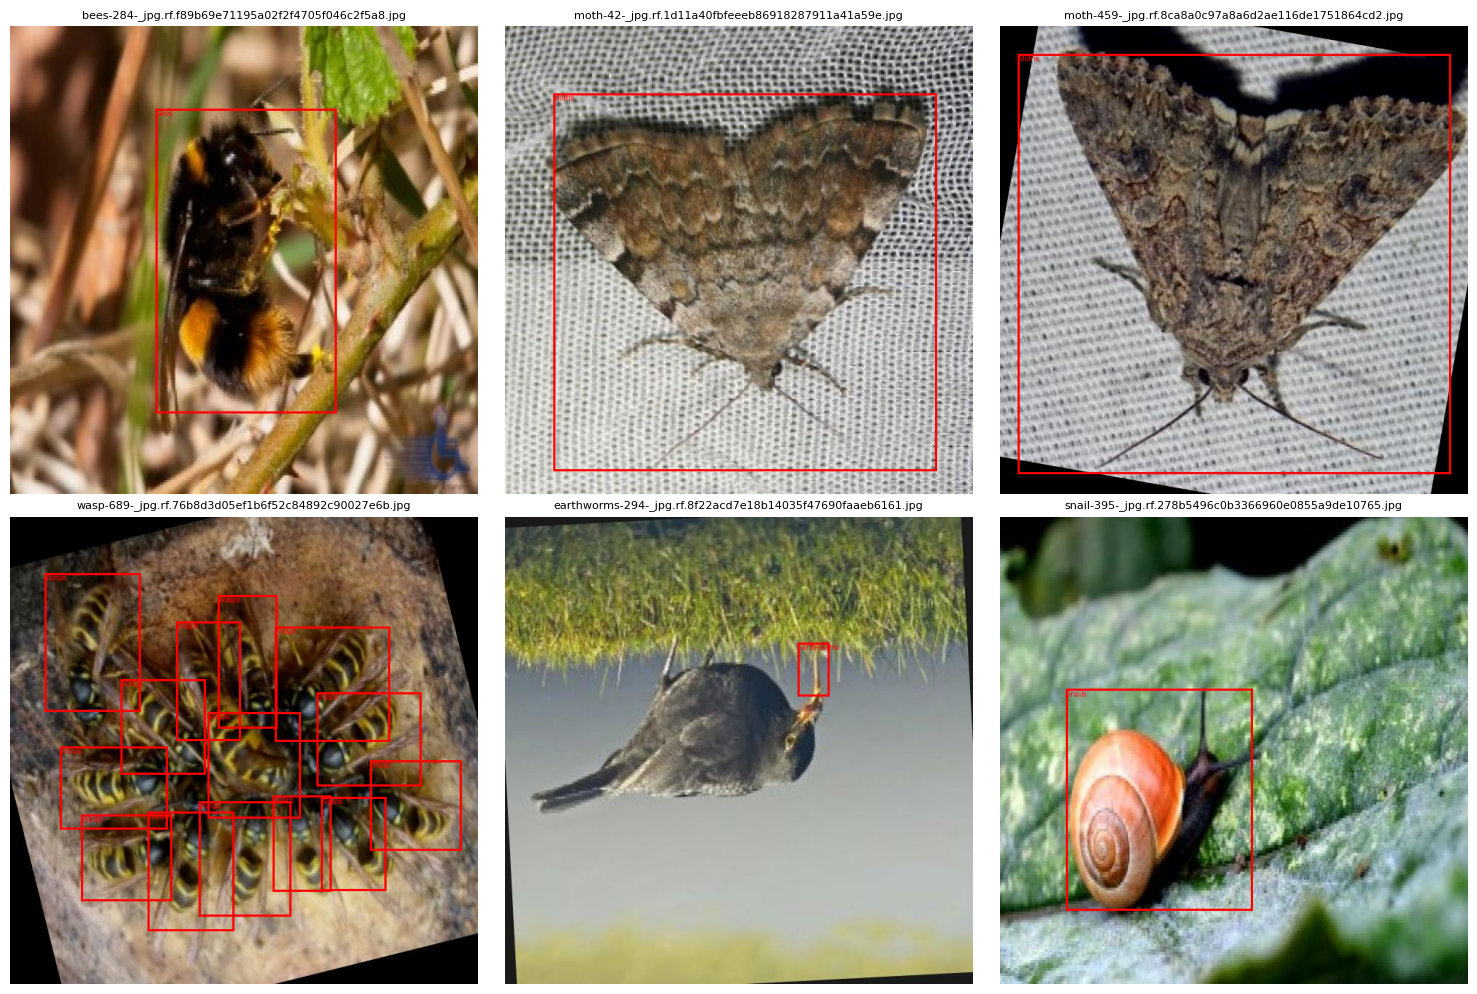

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

train_images_dir = train_path
train_labels_dir = train_path.replace("images", "labels")

image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

num_samples = 6
sample_images = random.sample(image_files, num_samples)

def draw_yolo_boxes(image_path, label_path):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    w, h = img.size

    if not os.path.exists(label_path):
        return img

    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, xc, yc, bw, bh = map(float, line.strip().split())

            x_center = xc * w
            y_center = yc * h
            box_w = bw * w
            box_h = bh * h

            # Compute box corners
            x1 = x_center - box_w / 2
            y1 = y_center - box_h / 2
            x2 = x_center + box_w / 2
            y2 = y_center + box_h / 2

            # Draw bounding box
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

            try:
                class_name = class_names[int(cls)]
                draw.text((x1, y1), class_name, fill="red")
            except:
                pass

    return img


# Plot images with boxes
plt.figure(figsize=(15, 10))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_images_dir, img_name)
    label_path = os.path.join(train_labels_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    img_with_boxes = draw_yolo_boxes(img_path, label_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(img_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Loading the YOLO12s Model and inspecting its architecture

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo12s.pt")

print("\n=== YOLO12s Model Loaded ===")
print(f"Total layers in model: {len(list(model.model.parameters()))}")


=== YOLO12s Model Loaded ===
Total layers in model: 360


## **Understanding YOLO12s Architecture**

YOLO models typically consist of three main components:

1. Backbone (Early Layers 0-9): Feature extraction from input images
   - These layers learn general features (edges, textures, patterns)
   - Pre-trained on large datasets (ImageNet, COCO)
   - These will be frozen for fine-tuning

2. Neck (Middle Layers 10-14): Feature fusion and aggregation
   - Combines features from different scales
   - These will be partially frozen

3. Head (Final Layers 15-22): Detection and classification
   - Produces bounding boxes and class predictions


In [ ]:
print("\n=== YOLO12s Architecture Summary ===")
print(model.model)

total_params = sum(p.numel() for p in model.model.parameters())
print(f"\nTotal parameters: {total_params:,}")



=== YOLO12s Architecture Summary ===
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     

## Freezing the Backbone Layers

- FROZEN LAYERS (Backbone - Layers 0-9): These layers extract general features and do not need retraining
- TRAINABLE LAYERS (Neck & Head - Layers 10-22): These layers will adapt to the pest detection task

This approach:
1. Preserves pre-trained knowledge from general object detection
2. Allows adaptation to crop pest specifics
3. Reduces training time and prevents overfitting
4. Requires less data to achieve good performance


In [ ]:
# Freeze the backbone layers (first 10 layers - indices 0-9)
freeze_layers = 10  # Freeze first 10 layers (backbone)

print("\n" + "="*80)
print("LAYER FREEZING CONFIGURATION FOR FINE-TUNING")
print("="*80)

frozen_count = 0
trainable_count = 0
frozen_params = 0
trainable_params = 0

for idx, (name, param) in enumerate(model.model.named_parameters()):
    if idx < freeze_layers:
        param.requires_grad = False
        frozen_count += 1
        frozen_params += param.numel()
        layer_type = "BACKBONE (FROZEN)"
    else:
        param.requires_grad = True
        trainable_count += 1
        trainable_params += param.numel()
        if idx < 15:
            layer_type = "NECK (TRAINABLE)"
        else:
            layer_type = "HEAD (TRAINABLE)"

    if idx < 5 or idx >= freeze_layers and idx < freeze_layers + 3 or idx >= len(list(model.model.named_parameters())) - 3:
        status = "🔒 FROZEN" if not param.requires_grad else "✅ TRAINABLE"
        print(f"Layer {idx:3d}: {status:15s} | {layer_type:20s} | {name[:60]}")
    elif idx == 5:
        print(f"         ...")

freeze_list = list(range(freeze_layers))

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nFROZEN LAYERS (Backbone):")
print(f"   - Layer indices: 0-{freeze_layers-1}")
print(f"   - Number of frozen parameter groups: {frozen_count}")
print(f"   - Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}% of total)")
print(f"   - Purpose: Preserve pre-trained feature extraction")

print(f"\nTRAINABLE LAYERS (Neck + Head):")
print(f"   - Layer indices: {freeze_layers}+")
print(f"   - Number of trainable parameter groups: {trainable_count}")
print(f"   - Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}% of total)")
print(f"   - Purpose: Adapt to AgroPest-12 dataset (crop pest detection)")

print(f"\nTotal Parameters: {total_params:,}")
print("="*80)

# Verifying the freeze
print(f"\n✓ Layer freezing complete. Ready for fine-tuning on AgroPest-12 dataset.")



LAYER FREEZING CONFIGURATION FOR FINE-TUNING
Layer   0: 🔒 FROZEN        | BACKBONE (FROZEN)    | model.0.conv.weight
Layer   1: 🔒 FROZEN        | BACKBONE (FROZEN)    | model.0.bn.weight
Layer   2: 🔒 FROZEN        | BACKBONE (FROZEN)    | model.0.bn.bias
Layer   3: 🔒 FROZEN        | BACKBONE (FROZEN)    | model.1.conv.weight
Layer   4: 🔒 FROZEN        | BACKBONE (FROZEN)    | model.1.bn.weight
         ...
Layer  10: ✅ TRAINABLE     | NECK (TRAINABLE)     | model.2.cv2.bn.weight
Layer  11: ✅ TRAINABLE     | NECK (TRAINABLE)     | model.2.cv2.bn.bias
Layer  12: ✅ TRAINABLE     | NECK (TRAINABLE)     | model.2.m.0.cv1.conv.weight
Layer 357: ✅ TRAINABLE     | HEAD (TRAINABLE)     | model.21.cv3.2.2.weight
Layer 358: ✅ TRAINABLE     | HEAD (TRAINABLE)     | model.21.cv3.2.2.bias
Layer 359: ✅ TRAINABLE     | HEAD (TRAINABLE)     | model.21.dfl.conv.weight

SUMMARY

🔒 FROZEN LAYERS (Backbone):
   - Layer indices: 0-9
   - Number of frozen parameter groups: 10
   - Frozen parameters: 36,000 

## Training the YOLO12s model

This cell trains the YOLO12s model with:
- Frozen backbone layers
- Trainable neck and head layers (adapted to pest detection)
- Advanced hyperparameters for optimal performance
- Data augmentation techniques for better generalization

Training Configuration:
- Epochs: 50
- Batch size: 8
- Learning rate: 0.0003
- Optimizer: AdamW
- Image size: 800x800
- Augmentation: Mosaic


In [ ]:
from ultralytics import YOLO

# The model already has frozen layers from the previous cell
# Now we train with freeze parameter to maintain the frozen state

print("\nStarting Fine-Tuning Training...\n")


model.train(
    data=yaml_path,
    epochs=50,
    imgsz=800,             # larger for small pests for better localization and higher precision
    batch=8,
    lr0=3e-4,
    lrf=0.01,
    optimizer='AdamW',
    weight_decay=5e-4,
    dropout=0.15,
    augment=True,
    mosaic=0.6,            # We reduced mosaic from the previous yolo12s run
    mixup=0.0,
    hsv_h=0.015, hsv_s=0.6, hsv_v=0.4,
    translate=0.05, scale=0.5, fliplr=0.5,
    freeze=list(range(freeze_layers)),
    patience=20,
    project='kaggle/working_LR',
    name='yolo12s_LR',
    val=True,
    save=True,
)

print("\nFine-tuning training completed!")



🚀 Starting Fine-Tuning Training...

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.9.16 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 8000, 45548MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.15, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=800, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=0.6, multi_scale=

## Verifying Layer States After Training


In [ ]:
print("\n=== Verifying Layer States After Training ===")
print("\nFrozen Layers (should be False):")
for idx, (name, param) in enumerate(model.model.named_parameters()):
    if idx < 5:
        print(f"Layer {idx}: {name[:50]:50s} | requires_grad={param.requires_grad}")

print("\nTrainable Layers (should be True):")
for idx, (name, param) in enumerate(model.model.named_parameters()):
    if idx >= freeze_layers and idx < freeze_layers + 3:
        print(f"Layer {idx}: {name[:50]:50s} | requires_grad={param.requires_grad}")

print("\n✓ Layer state verification complete.")



=== Verifying Layer States After Training ===

Frozen Layers (should be False):
Layer 0: model.0.conv.weight                                | requires_grad=False
Layer 1: model.0.bn.weight                                  | requires_grad=False
Layer 2: model.0.bn.bias                                    | requires_grad=False
Layer 3: model.1.conv.weight                                | requires_grad=False
Layer 4: model.1.bn.weight                                  | requires_grad=False

Trainable Layers (should be True):
Layer 10: model.2.cv2.bn.weight                              | requires_grad=False
Layer 11: model.2.cv2.bn.bias                                | requires_grad=False
Layer 12: model.2.m.0.cv1.conv.weight                        | requires_grad=False

✓ Layer state verification complete.


## Saving the Fine-Tuned Model


In [ ]:
from ultralytics import YOLO
import os

project_dir = 'kaggle/working_LR/finalproject'
os.makedirs(project_dir, exist_ok=True)

trained_model_path = os.path.join(project_dir, 'crop_pest_detection_yolo12s_finetuned.pt')

model.save(trained_model_path)
print(f"[INFO] Fine-tuned YOLO12n model saved at: {trained_model_path}")


[INFO] Fine-tuned YOLO12n model saved at: kaggle/working_LR/finalproject/crop_pest_detection_yolo12s_finetuned.pt


## Evaluating the Model on the Validation Set


In [ ]:
from ultralytics import YOLO

model = YOLO(trained_model_path)

metrics = model.val(data=yaml_path)
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list containing mAP50-95 for each category

Ultralytics 8.3.233 🚀 Python-3.9.16 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 8000, 45548MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 695.4±118.3 MB/s, size: 40.4 KB)
val: Scanning /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 3.2Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 4.6it/s 15.1s0.2s
                   all       1095       1341       0.78      0.619      0.681      0.398
                  Ants         96        178      0.825      0.475      0.603      0.236
                  Bees         99        110      0.795      0.664      0.732      0.353
               Beetles         89        100      0.613      0.476       0.52      0.251
          Caterpillars         77        139      

array([    0.23581,     0.35285,     0.25051,     0.18523,     0.24485,      0.3457,     0.34034,       0.685,       0.323,      0.6029,     0.58076,     0.62785])

## Performance Metrics on the Validation Set


In [ ]:
from ultralytics import YOLO

trained_model = YOLO(trained_model_path)

metrics = trained_model.val(data=yaml_path)
print("\n" + "="*60)
print("VALIDATION SET METRICS - YOLO12n Fine-Tuned")
print("="*60)
print(f" Precision:   {metrics.box.mp:.3f}")
print(f" Recall:      {metrics.box.mr:.3f}")
print(f" mAP@50:      {metrics.box.map50:.3f}")
print(f" mAP@50-95:   {metrics.box.map:.3f}")
print("="*60)


Ultralytics 8.3.233 🚀 Python-3.9.16 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 8000, 45548MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 700.9±163.6 MB/s, size: 41.5 KB)
val: Scanning /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/valid/labels.cache... 1095 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1095/1095 3.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 69/69 4.5it/s 15.3s0.2s
                   all       1095       1341       0.78      0.619      0.681      0.398
                  Ants         96        178      0.825      0.475      0.603      0.236
                  Bees         99        110      0.795      0.664      0.732      0.353
               Beetles         89        100      0.613      0.476       0.52      0.251
          Caterpillars         77        139      

## Evaluating on the Test Set


In [ ]:
from ultralytics import YOLO

model = YOLO(trained_model_path)

test_results = model.val(data=yaml_path, split='test')

print("\n" + "="*60)
print("TEST SET METRICS - YOLO12n Fine-Tuned")
print("="*60)
print(f" Precision:   {test_results.box.mp:.3f}")
print(f" Recall:      {test_results.box.mr:.3f}")
print(f" mAP@50:      {test_results.box.map50:.3f}")
print(f" mAP@50-95:   {test_results.box.map:.3f}")
print("="*60)


Ultralytics 8.3.233 🚀 Python-3.9.16 torch-2.8.0+cu128 CUDA:0 (Quadro RTX 8000, 45548MiB)
YOLOv12s summary (fused): 159 layers, 9,235,524 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.3 ms, read: 325.4±304.7 MB/s, size: 39.9 KB)
val: Scanning /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/labels.cache... 546 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 908.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 4.3it/s 8.2s0.2s
                   all        546        689      0.775      0.612      0.686      0.393
                  Ants         54         87       0.78      0.489       0.62      0.249
                  Bees         40         44      0.863      0.864      0.854        0.4
               Beetles         41         44      0.645      0.453      0.551      0.275
          Caterpillars         46         93      0.624

## Plotting Predictions on Test Images



🔍 Running predictions on sample test images...


image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/catterpillar-125-_jpg.rf.b95ad740a3eb2676dfb50643dd7976c8.jpg: 640x640 (no detections), 10.1ms
Speed: 1.6ms preprocess, 10.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/catterpillar-353-_jpg.rf.b96488b86472262e357a95d5037cf551.jpg: 640x640 (no detections), 10.6ms
Speed: 1.6ms preprocess, 10.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


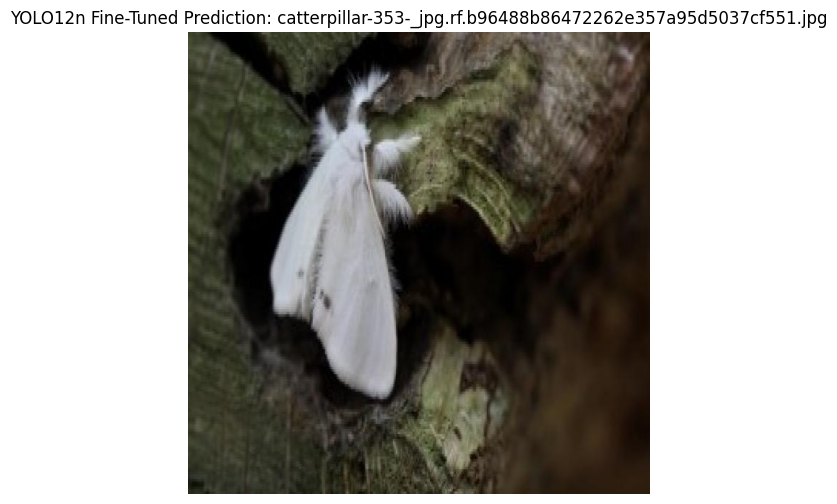


image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/earthworms-154-_jpg.rf.2a68245034d4a480ae9189ad7ddd2d4f.jpg: 640x640 (no detections), 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


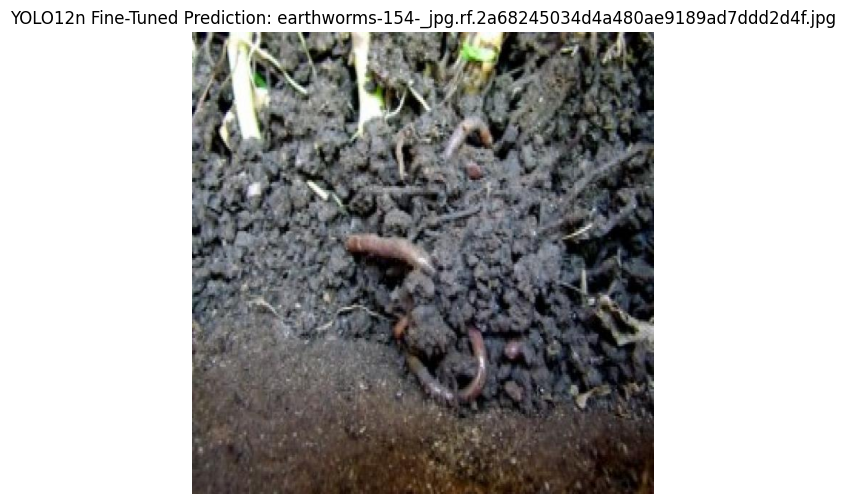


image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/snail-116-_jpg.rf.6e21acbb8d5a2b1cd71f5acb79497b03.jpg: 640x640 (no detections), 11.1ms
Speed: 1.8ms preprocess, 11.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


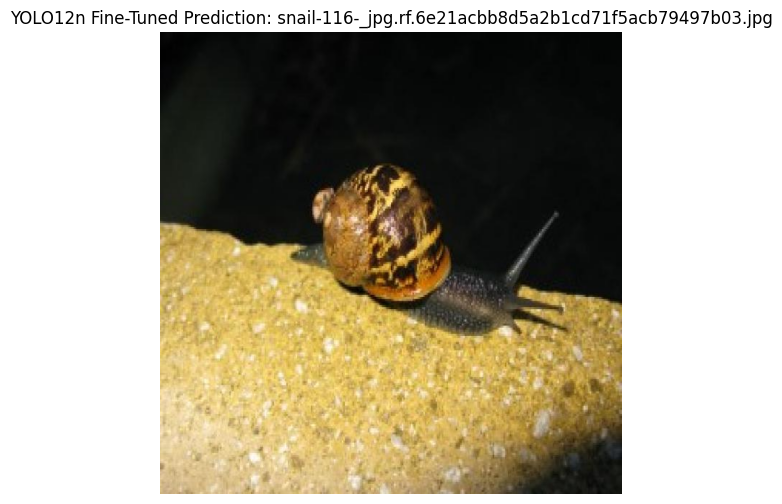


image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/Weevil-44-_jpg.rf.a004be02b523187d63847aa77813f6ef.jpg: 640x640 1 bear, 11.0ms
Speed: 1.7ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 /home/rj2440/.cache/kagglehub/datasets/rupankarmajumdar/crop-pests-dataset/versions/2/test/images/Weevil-452-_jpg.rf.e4be68b91dbd6fff8730557c1718a9f5.jpg: 640x640 3 birds, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

model = YOLO(trained_model_path)

test_images_dir = test_path

test_image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
sample_test_images = random.sample(test_image_files, min(6, len(test_image_files)))

test_images = [os.path.join(test_images_dir, img) for img in sample_test_images]

print("\nRunning predictions on sample test images...\n")

for img_path in test_images:
    results = model.predict(img_path)

    annotated_img = results[0].plot()
    # Converting BGR to RGB for matplotlib
    annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_img)
    plt.title(f"YOLO12n Fine-Tuned Prediction: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()
